# Impacto de la computación en las industrias convencionales

El proposito de esta investigacion es evaluar como los avances en la computacion en la ultimas decadas han impactado en los negocios convencionales.

Para evaluar el impacto en una determinada industria, se buscara si es posible encontrar correlaciones y posteriormente, si es posible proyectar regresiones lineales, polinomicas o lineales multiples, de poder realizarse estas regresiones, el coeficiente de estas nos indicara cuanto peso ha tenido una determinada tecnologia.

Como regla analizaremos industrias que existian mucho antes de la computacion, como por ejemplo los bienes raices, tambien se intento analizar la industria de los libros, pero debido a escasez de tiempo, solo se pudo realizar una limpieza de los datos y outliers.

## Metodologia

### Busqueda de los datasets

Se realizo una busqueda de datasets que contengan registros de productos relacionados a la computacion, se encontraron en total unos 6 datasets obtenidos de [wikipedia - cantidad de transistores](https://en.wikipedia.org/wiki/Transistor_count) usando [wikitable2csv.ggor.de](https://wikitable2csv.ggor.de/) para extraer las siguientes tablas de datos:
- Memorias Flash.
- FPGA.
- GPU.
- Microprocesadores.
- RAM.
- ROM.

Tambien del [worldbank.org](https://data.worldbank.org/) se obtuvo los siguientes 3 datasets:
- Porcentaje de la poblacion con internet.
- Poblacion (puede ser de utilidad para normalizar aunque no se llego con el plazo para aplicarlo).
- GDP (puede ser de utilidad para hacer comparaciones aunque no se llego con el plazo para aplicarlo).

Los datasets utilizados para las industrias fueron:
- Ventas de bienes raices (el cual fue completamente analizado) fue obtenido de [catalog.data.gov/dataset/real-estate-sales-2001-2018](https://catalog.data.gov/dataset/real-estate-sales-2001-2018), aunque en la url indique ventas desde el 2001 hasta 2018, en realidad contiene registros hasta el 2020.
- Top de libros publicados (se limpiaron los datos, eliminacion de outliers pero no se llego con los plazos para finalizarlo) fue obtenido de [scostap - Goodreads Best Book Ever dataset](https://github.com/scostap/goodreads_bbe_dataset).

### Limpieza de los datos

Los datos obtenidos de Wikipedia originalmente tenian monton de irregularidades que son propias de las tablas de esta plataforma, como celdas con referencias a otras paginas, fechas de lanzamiento con formatos inconsistentes, numeros flotantes escritos con commas. Todas estas irregularidades tuvieron que ser eliminadas para poder realizar un posterior analisis.

Por otro lado los datos obtenidos del World Bank Data, como Internet, Poblacion y GDP, poseian como columnas los años y un registro por cada pais, para limpiar estos datasets, primero se filtro el pais de interes y luego se transpuso la tabla para que los valores anuales esten en filas.

Una vez limpios estos datos, se procedio por fusionar por fecha todos los datasets en un par de dataframes para agrupar todas las columnas en comun, por ejemplo:
- microprocesadores, gpus, ... ,flash => computacion_dfs
- br_ventas_por_anio, ventas_por_tipo, br_inversiones_por_anio => bienes_raices

### Analisis exploratorio

Lo primero que se hizo para empezar el analisis fue fusionar los datasets de las industrias que nos interesan, en este caso bienes_raices + computacion.

Luego este dataset fusionado se utilizo para ver si podemos observar correlaciones entre sus columnas mediante un mapa de calor y luego una grafica de pares (pairplot).

### Proyeccion de regresiones

Mediante el analisis explotario previo, se procedio a seleccionar un par de las tantas correlaciones encontradas y luego se proyectaron regresiones lineales y polinomicas, tambien se utilizo regresiones lineales multiples para saber con que coeficiente impacto cada una de las tecnologias.


### Dependencias

In [72]:
# Standard packages
import pandas as pd
import numpy as np
import re

# Installed packages
from IPython.display import display
from matplotlib import pyplot as plt
%pip install seaborn
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Local packages
# NOTE:
#   Evitaremos tener que usar modulos locales externos a
#   este notebook de Jupiter para facilitar el uso en la
#   plataforma Google Colab.

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Parametros constantes que utilizaremos

In [73]:
# Constantes
COLUMNA_FECHA = 'Año'
FECHA_MIN = 2001
FECHA_MAX = 2020
DATASETS_FOLDER = './content'
# Utilizaremos esta para indicar si queremos
# guardar el postprocesado de un dataset,
# util si el dataset original es muy pesado.
GUARDAR_DATOS_PROCESADOS = False

# Global state
poblacion = None # Usado para normalizar los datos

### Procesando datos relacionados a la industria de la computacion

Como se menciono anteriormente, se procedera a limpiar, extraer las columnas revelantes y fusionar los datasets de microprocesadores, flash, fpga, gpus, ram, rom e internet.

Los pasos llevados a cabo durante esta etapa para limpiar los datos de los multiples datasets, provenientes de Wikipedia, por lo general seran:
1. eliminar columnas innecesarias.
1. extraer el año y guardarlo en una columna 'fecha', no tratamos directamente la fecha ya que pueden estar presente de manera inconsistente, sin seguir un formato especifico.
1. remover comas de los numeros flotantes.
1. convertir a flotante las columnas string que representan numeros.
1. filtramos los registros que esten entre un rango de años.
1. solo nos quedamos con los mayores valores de cada año en una determinada columna, ya que solo nos interesa el avance de la technologia, es decir, por ejemplo, la mayor cantidad de transistores.
1. eliminamos valores Nan.

Finalmente fusionamos este dataframe a uno mas general por fecha.

In [74]:
# En esta lista vamos a ir agregando los diferentes dataframes
# que mas adelante fusionaremos en uno solo.
computacion_dfs = []

In [75]:
def asegurar_tipo_de_dato_fecha(df: pd.DataFrame, columna_fecha:str=COLUMNA_FECHA) -> pd.DataFrame:
    """Aseguramos que el tipo de dato de la fecha es un entero, no de tipo fecha porque solo tenemos el anio"""
    df[columna_fecha] = df[columna_fecha].astype(int)
    return df

def mantener_columnas(df:pd.DataFrame, columnas:list) -> pd.DataFrame:
    """Mantiene solo las COLUMNAS especificadas en un DF"""
    return df[columnas]

def fecha_a_anio(df:pd.DataFrame, columna_fecha:str) -> pd.DataFrame:
    """Convierte COLUMNA_FECHA a un entero ANIO y cambia el nombre de la columna a 'Año'"""
    # Convert to year
    fecha_regex = r'\d{4}'
    df[columna_fecha] = df[columna_fecha].astype(str)
    df = df[df[columna_fecha].str.contains(fecha_regex)]
    df[columna_fecha] = df[columna_fecha].apply(lambda x: re.findall(fecha_regex, x)[0])
    # Rename
    if columna_fecha != COLUMNA_FECHA:
        df = df.rename(columns={columna_fecha: COLUMNA_FECHA})
    return df

def remover_commas(df:pd.DataFrame) -> pd.DataFrame:
    """Remueve commas de las columnas"""
    return df.apply(lambda x: x.str.replace(',', ''))

def convertir_a_flotante(df:pd.DataFrame, columnas:list) -> pd.DataFrame:
    """Convierte las columnas especificadas a flotante"""
    for col in columnas:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def cortar_agregar_anios(
        df: pd.DataFrame,
        columna_fecha:str=COLUMNA_FECHA,
        min_anio:int=FECHA_MIN,
        max_anio:int=FECHA_MAX
        ) -> pd.DataFrame:
    """Corta un dataframe DF en los anios especificados, agregando los anios faltantes"""
    df = asegurar_tipo_de_dato_fecha(df, columna_fecha)
    # Add missing years
    for year in range(min_anio, max_anio):
        if year not in df[columna_fecha].values:
            df = pd.concat([df, pd.DataFrame.from_records([{ columna_fecha: year }])])
    df = df.sort_values(by=[columna_fecha]).reset_index(drop=True)
    # Cut
    df = df[(df[columna_fecha] >= min_anio) & (df[columna_fecha] <= max_anio)]
    return df

def mantener_solo_valor_mas_alto(
        df: pd.DataFrame,
        columna_valor:str,
        columna_fecha:str=COLUMNA_FECHA
        ) -> pd.DataFrame:
    """Mantiene solo el valor mas alto por fecha, util cuando queremos ver el
       avance de una technologia, solo nos interesa el valor mas alto"""
    df = df.sort_values(by=[columna_fecha, columna_valor], ascending=False)
    df = df.drop_duplicates(subset=[columna_fecha], keep='first')
    # Back to the original order
    df = df.sort_values(by=[columna_fecha]).reset_index(drop=True)
    return df

def columna_fecha_a_fila(df:pd.DataFrame, pais:str, nueva_columna:str) -> pd.DataFrame:
    """Convierte columnas fecha a fila, filtrando por pais, esto es util para datasets del World Bank Data"""
    # Filter rows by country
    df = df[df['Country Name'] == pais]
    # Remove columns that are not a year
    df = df[df.columns[df.columns.str.contains(r'\d{4}')]]
    # Convert columns to rows
    df = df.melt(id_vars=[], var_name=COLUMNA_FECHA, value_name=nueva_columna)
    return df

def normalizar_con_la_poblacion(df:pd.DataFrame, column:str) -> pd.DataFrame:
    """Normalizamos una COLUMNA de un dataframe DF con la poblacion"""
    return df ## TODO: fix this
    assert poblacion is not None, 'El dataframe Poblacion no fue cargado'
    df[column] = np.divide(df[column], poblacion['US Population']) * 100
    return df

def fusionar_por_fecha(dataframes:list) -> pd.DataFrame:
    """Fusiona los DATAFRAMES por fecha,
       NOTE: todos los dataframes deben tener la misma cantidad de filas"""
    resultado = pd.DataFrame()
    resultado[COLUMNA_FECHA] = dataframes[0][COLUMNA_FECHA].unique()
    resultado = asegurar_tipo_de_dato_fecha(resultado)
    for df in dataframes:
        df = asegurar_tipo_de_dato_fecha(df)
        resultado = pd.merge(resultado, df, on=COLUMNA_FECHA, how='outer')
    resultado = cortar_agregar_anios(resultado)
    return resultado

* Memoria Flash

Este dataset presenta las columnas:
- Chip name: nombre del chip.
- Capacity: capacidad en bits del chip.
- Flash type: tipo de memoria flash.
- FGMOS transistor count: cantidad de transistores.
- Date of introduction: fecha de introduccion.
- Manufacturer(s): fabricante.
- Process: tamaño del fabricacion en nm.
- Area: area del chip en mm2.
- Transistor density (tr./mm2): dencidad de transistores
- Ref: referencia de wikipedia

Solamente nos quedaremos con las columnas "Date of introduction" y "FGMOS transistor count" ya que la cantidad de transistores es una buena manera de medir el avance tecnologico.

In [76]:
flash = pd.read_csv(f'{DATASETS_FOLDER}/flash.csv')
flash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Chip name                    24 non-null     object 
 1   Capacity (bits)              24 non-null     object 
 2   Flash type                   24 non-null     object 
 3   FGMOS transistor count       24 non-null     object 
 4   Date of introduction         24 non-null     object 
 5   Manufacturer(s)              24 non-null     object 
 6   Process                      24 non-null     object 
 7   Area                         24 non-null     object 
 8   Transistor density, tr./mm2  24 non-null     object 
 9   Ref                          0 non-null      float64
dtypes: float64(1), object(9)
memory usage: 2.0+ KB


Memoria Flash: limpieza

In [77]:
flash = mantener_columnas(flash, ['FGMOS transistor count', 'Date of introduction'])
flash = fecha_a_anio(flash, 'Date of introduction')
flash = remover_commas(flash)
flash = convertir_a_flotante(flash, ['FGMOS transistor count'])
flash = cortar_agregar_anios(flash)
flash = mantener_solo_valor_mas_alto(flash, 'FGMOS transistor count')
flash = flash.fillna(method='ffill')
computacion_dfs.append(flash)

Memoria Flash: revision de los datos limpiados

,FGMOS transistor count,Año
count,1.900000e+01,19.000000
mean,3.829278e+11,2010.000000
std,5.649140e+11,5.627314
min,5.368709e+08,2001.000000
25%,2.576980e+10,2005.500000
50%,2.560000e+11,2010.000000
75%,2.560000e+11,2014.500000
max,2.048000e+12,2019.000000


,FGMOS transistor count,Año
14,2.560000e+11,2015
15,2.560000e+11,2016
16,1.365333e+12,2017
17,1.365333e+12,2018
18,2.048000e+12,2019


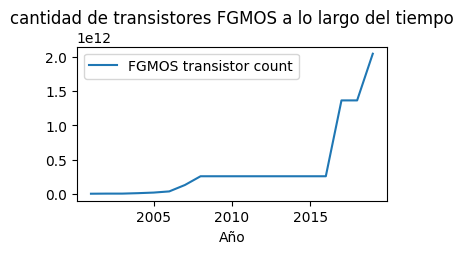

In [78]:
display(flash.describe())
display(flash.tail())
flash.plot(
    x=COLUMNA_FECHA,
    y='FGMOS transistor count',
    title='cantidad de transistores FGMOS a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

* FPGA (matriz de puertas lógicas programable en campo)

Este dataset presenta las columnas:
- FPGA: nombre del modelo de FPGA.
- Transistor count: cantidad de transistores.
- Date of introduction: fecha de introduccion.
- Designer: nombre del diseñador.
- Manufacturer: nombre del fabricante.
- Process: tamaño de la fabricacion en nm.
- Area: area en mm2.
- Transistor density (tr./mm2): dencidad de transistores.
- Ref: columna de referencia utilizada en Wikipedia.

De todas estas columnas, al igual que con la memoria Flash, luego de la limpieza solo nos quedaremos con la fecha de introduccion y la cantidad de transistores.

In [79]:
fpga = pd.read_csv(f'{DATASETS_FOLDER}/fpga.csv')
fpga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   FPGA                         16 non-null     object 
 1   Transistor count             16 non-null     object 
 2   Date of introduction         16 non-null     object 
 3   Designer                     16 non-null     object 
 4   Manufacturer                 11 non-null     object 
 5   Process                      13 non-null     object 
 6   Area                         3 non-null      object 
 7   Transistor density, tr./mm2  3 non-null      object 
 8   Ref                          0 non-null      float64
dtypes: float64(1), object(8)
memory usage: 1.2+ KB


FPGA: limpieza de los datos

In [80]:
fpga = mantener_columnas(fpga, ['Transistor count', 'Date of introduction'])
fpga = fecha_a_anio(fpga, 'Date of introduction')
fpga = remover_commas(fpga)
fpga = convertir_a_flotante(fpga, ['Transistor count'])
fpga = cortar_agregar_anios(fpga)
fpga = fpga.rename(columns={'Transistor count': 'FPGA transistor count'})
fpga = mantener_solo_valor_mas_alto(fpga, 'FPGA transistor count')
fpga = fpga.fillna(method='ffill')
computacion_dfs.append(fpga)

/tmp/ipykernel_18780/3894518175.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columna_fecha] = df[columna_fecha].apply(lambda x: re.findall(fecha_regex, x)[0])


FPGA: muestreo del dataset limpio

,FPGA transistor count,Año
15,2.000000e+10,2016
16,2.000000e+10,2017
17,2.000000e+10,2018
18,4.330000e+10,2019
19,3.500000e+10,2020


,FPGA transistor count,Año
count,1.900000e+01,20.00000
mean,1.034526e+10,2010.50000
std,1.259800e+10,5.91608
min,4.300000e+08,2001.00000
25%,1.100000e+09,2005.75000
50%,5.300000e+09,2010.50000
75%,2.000000e+10,2015.25000
max,4.330000e+10,2020.00000


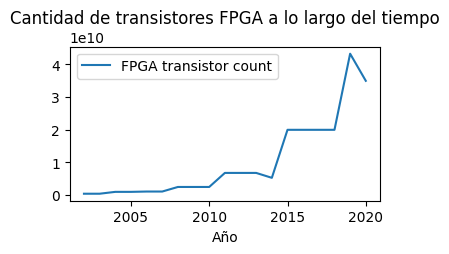

In [81]:
display(fpga.tail())
display(fpga.describe())
fpga.plot(
    x=COLUMNA_FECHA,
    y='FPGA transistor count',
    title='Cantidad de transistores FPGA a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

* GPU (unidad de procesamiento gráfico)

Este dataset presenta las columnas:
- Processor: nombre del modelo de procesador.
- Transistor count: cantidad de transistores.
- Year: año de lanzamiento.
- Designer(s): nombre del diseñador.
- Fab(s): nombre del fabricante.
- Process: tamaño de la fabricacion en nm.
- Area: area en mm2.
- Transistor density, (tr./mm2): dencidad de transistores.
- Ref: columna de referencia utilizada en Wikipedia.

De todas estas columnas, al igual que con los anteriores datasets, luego de la limpieza solo nos quedaremos con el año de lanzamiento y la cantidad de transistores.

In [82]:
gpus = pd.read_csv(f'{DATASETS_FOLDER}/gpus.csv')
gpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Processor                    163 non-null    object 
 1   Transistor count             163 non-null    object 
 2   Year                         163 non-null    int64  
 3   Designer(s)                  163 non-null    object 
 4   Fab(s)                       163 non-null    object 
 5   Process                      163 non-null    object 
 6   Area                         163 non-null    object 
 7   Transistor density, tr./mm2  163 non-null    object 
 8   Ref                          0 non-null      float64
dtypes: float64(1), int64(1), object(7)
memory usage: 11.6+ KB


GPUs: limpieza del dataset

In [83]:
gpus = mantener_columnas(gpus, ['Transistor count', 'Year'])
gpus = fecha_a_anio(gpus, 'Year')
gpus = remover_commas(gpus)
gpus = convertir_a_flotante(gpus, ['Transistor count'])
gpus = cortar_agregar_anios(gpus)
gpus = gpus.rename(columns={'Transistor count': 'GPU transistor count'})
gpus = mantener_solo_valor_mas_alto(gpus, 'GPU transistor count')
gpus = gpus.fillna(method='ffill')
computacion_dfs.append(gpus)

GPUs: muestreo del dataset limpio

,GPU transistor count,Año
15,1.530000e+10,2016
16,2.110000e+10,2017
17,1.860000e+10,2018
18,1.030000e+10,2019
19,5.420000e+10,2020


,GPU transistor count,Año
count,2.000000e+01,20.00000
mean,8.016336e+09,2010.50000
std,1.260009e+10,5.91608
min,6.000000e+07,2001.00000
25%,5.910000e+08,2005.75000
50%,3.756356e+09,2010.50000
75%,9.250000e+09,2015.25000
max,5.420000e+10,2020.00000


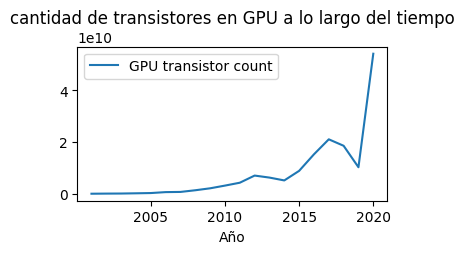

In [84]:
display(gpus.tail())
display(gpus.describe())
gpus.plot(
    x=COLUMNA_FECHA,
    y='GPU transistor count',
    title='cantidad de transistores en GPU a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

* Microprocesador

Este dataset presenta las columnas:
- Processor: nombre del modelo de procesador.
- Transistor count: cantidad de transistores.
- Year: año de lanzamiento.
- Designer: nombre del diseñador.
- Process (nm): tamaño de la fabricacion en nm.
- Area (mm2): area en mm2.
- Transistor density, tr./mm2: dencidad de transistores.

De todas las columnas solo nos quedaremos con el año de lanzamiento y la cantidad de transistores.

In [85]:
microprocesadores = pd.read_csv(f'{DATASETS_FOLDER}/microprocessors.csv')
microprocesadores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Processor                    234 non-null    object
 1   Transistor count             234 non-null    object
 2   Year                         234 non-null    object
 3   Designer                     234 non-null    object
 4   Process
(nm)                 234 non-null    object
 5   Area (mm2)                   234 non-null    object
 6   Transistor density, tr./mm2  234 non-null    object
dtypes: object(7)
memory usage: 12.9+ KB


Microprocesadores: limpieza del dataset

In [86]:
microprocesadores = mantener_columnas(microprocesadores, ['Transistor count', 'Year'])
microprocesadores = fecha_a_anio(microprocesadores, 'Year')
microprocesadores = remover_commas(microprocesadores)
microprocesadores = microprocesadores[microprocesadores['Transistor count'].str.contains(r'^\d+$')]
microprocesadores = convertir_a_flotante(microprocesadores, ['Transistor count'])
microprocesadores = microprocesadores.rename(columns={'Transistor count': 'Microprocessor transistor count'})
microprocesadores = cortar_agregar_anios(microprocesadores)
microprocesadores = mantener_solo_valor_mas_alto(microprocesadores, 'Microprocessor transistor count')
microprocesadores = microprocesadores.fillna(method='ffill')
computacion_dfs.append(microprocesadores)

/tmp/ipykernel_18780/3894518175.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columna_fecha] = df[columna_fecha].apply(lambda x: re.findall(fecha_regex, x)[0])


Microprocesadores: muestreo del dataset limpio

,Microprocessor transistor count,Año
15,8000000000,2016
16,19200000000,2017
17,10000000000,2018
18,39540000000,2019
19,16000000000,2020


,Microprocessor transistor count,Año
count,2.000000e+01,20.00000
mean,6.507800e+09,2010.50000
std,9.477374e+09,5.91608
min,1.910000e+08,2001.00000
25%,7.397500e+08,2005.75000
50%,2.450000e+09,2010.50000
75%,8.500000e+09,2015.25000
max,3.954000e+10,2020.00000


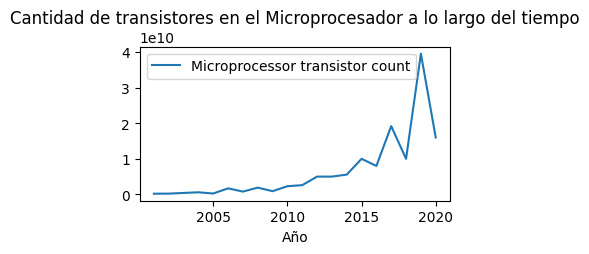

In [87]:
display(microprocesadores.tail())
display(microprocesadores.describe())
microprocesadores.plot(
    x=COLUMNA_FECHA,
    y='Microprocessor transistor count',
    title='Cantidad de transistores en el Microprocesador a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

* RAM (memoria de acceso aleatorio)

Este dataset presenta las columnas:
- Chip name: nombre del chip.
- Capacity (bits): capacidad en bits del chip.
- RAM type: tipo de memoria RAM.
- Transistor count: cantidad de transistores.
- Date of introduction: fecha de introduccion.
- Manufacturer(s): fabricante.
- Process: tamaño de la fabricacion en nm.
- Area: area en mm2.
- Transistor density, tr./mm2: dencidad de transistores.
- Ref: columna de referencia utilizada en Wikipedia.

De todas las columnas solo nos quedaremos con la fecha de introduccion y la cantidad de transistores.

In [88]:
ram = pd.read_csv(f'{DATASETS_FOLDER}/ram.csv')
ram.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Chip name                    48 non-null     object 
 1   Capacity (bits)              48 non-null     object 
 2   RAM type                     48 non-null     object 
 3   Transistor count             48 non-null     object 
 4   Date of introduction         48 non-null     object 
 5   Manufacturer(s)              48 non-null     object 
 6   Process                      48 non-null     object 
 7   Area                         48 non-null     object 
 8   Transistor density, tr./mm2  48 non-null     object 
 9   Ref                          0 non-null      float64
dtypes: float64(1), object(9)
memory usage: 3.9+ KB


RAM: limpieza del dataset

In [89]:
ram = mantener_columnas(ram, ['Date of introduction', 'Transistor count'])
ram = fecha_a_anio(ram, 'Date of introduction')
ram = remover_commas(ram)
ram = convertir_a_flotante(ram, ['Transistor count'])
ram = ram.rename(columns={'Transistor count': 'RAM transistor count'})
ram = cortar_agregar_anios(ram)
ram = mantener_solo_valor_mas_alto(ram, 'RAM transistor count')
ram = ram.fillna(method='ffill')
# MALO: computacion_dfs.append(ram) este dataset tiene un monton Nan values

RAM: muestreo del dataset limpio

,Año,RAM transistor count
14,2015,1.717987e+10
15,2016,3.435974e+10
16,2017,6.871948e+10
17,2018,1.374390e+11
18,2019,1.374390e+11


,Año,RAM transistor count
count,19.000000,1.200000e+01
mean,2010.000000,4.294967e+10
std,5.627314,4.661933e+10
min,2001.000000,1.717987e+10
25%,2005.500000,1.717987e+10
50%,2010.000000,1.717987e+10
75%,2014.500000,4.294967e+10
max,2019.000000,1.374390e+11


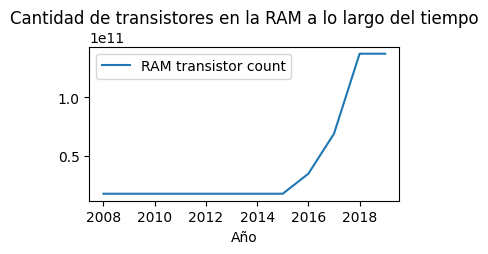

In [90]:
display(ram.tail())
display(ram.describe())
ram.plot(
    x=COLUMNA_FECHA,
    y='RAM transistor count',
    title='Cantidad de transistores en la RAM a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

Luego de ver los datos procesados y limpios de la RAM, se puede llegar a la conclusion de que lo mejor seria descartar este dataset ya que tiene demaciados valores Nan

* ROM (memoria de solo lectura)

Este dataset presenta las columnas:
- Chip name: nombre del chip.
- Capacity (bits): capacidad en bits del chip.
- ROM type: tipo de memoria ROM.
- Transistor count: cantidad de transistores.
- Date of introduction: fecha de introduccion.
- Manufacturer(s): fabricante.
- Process: tamaño de la fabricacion en nm.
- Area: area en mm2.
- Ref: columna de referencia utilizada en Wikipedia.

De todas las columnas solo nos quedaremos con la fecha de introduccion y la cantidad de transistores.

In [91]:
rom = pd.read_csv(f'{DATASETS_FOLDER}/rom.csv')
rom.tail()

,Chip name,Capacity (bits),ROM type,Transistor count,Date of introduction,Manufacturer(s),Process,Area,Ref
17,27512,512 Kb,EPROM (HMOS),"524,288",1984,Intel,?,?,NaN
18,?,1 Mb,EPROM (CMOS),"1,048,576",1984,NEC,"1,200 nm",?,NaN
19,?,4 Mb,EPROM (CMOS),"4,194,304",1987,Toshiba,800 nm,?,NaN
20,?,16 Mb,EPROM (CMOS),"16,777,216",1990,NEC,600 nm,?,NaN
21,?,16 Mb,MROM,"16,777,216",1995,"AKM, Hitachi",?,?,NaN


ROM: limpieza del dataset

In [92]:
rom = mantener_columnas(rom, ['Date of introduction', 'Transistor count'])
rom = fecha_a_anio(rom, 'Date of introduction')
rom = remover_commas(rom)
rom = convertir_a_flotante(rom, ['Transistor count'])
rom = rom.rename(columns={'Transistor count': 'ROM transistor count'})
rom = cortar_agregar_anios(rom)
rom = mantener_solo_valor_mas_alto(rom, 'ROM transistor count')
rom = rom.fillna(method='ffill')
# MALO: computacion_dfs.append(rom) este no tiene suficientes datos validos

ROM: muestreo del dataset limpio

,Año,ROM transistor count
14,2015,NaN
15,2016,NaN
16,2017,NaN
17,2018,NaN
18,2019,NaN


,Año,ROM transistor count
count,19.000000,0.0
mean,2010.000000,NaN
std,5.627314,NaN
min,2001.000000,NaN
25%,2005.500000,NaN
50%,2010.000000,NaN
75%,2014.500000,NaN
max,2019.000000,NaN


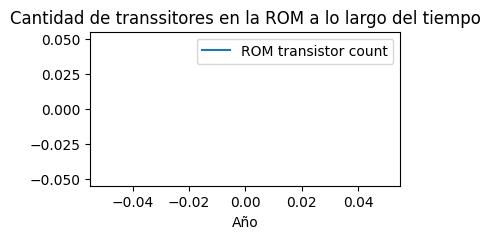

In [93]:
display(rom.tail())
display(rom.describe())
rom.plot(
    x=COLUMNA_FECHA,
    y='ROM transistor count',
    title='Cantidad de transsitores en la ROM a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

Como observamos en el muestreo de datos luego de la limpieza, al igual que con la RAM, vamos a descartar los datos de la ROM ya que faltan demaciados registros desde el 2000 hasta la actualidad.

* Internet

Este dataset presenta las columnas:
- Country Name: nombre del pais.
- Country Code: codigo ISO del pais.
- Indicator Name: nombre del indicador.
- Indicator Code: codigo del indicador.
- 1960, 1961, ..., 2023: porcentajes de internet por año.

Ya que este dataset fue obtenido del World Bank Data y no tiene irregularidades en los datos, los pasos para procesar a este dataset seran diferentes a los demas:
1. filtramos el pais de interes (Estados Unidos).
1. convertimos las columnas de años en filas.
1. agregamos este dataframe a uno mas general, fusionando por fecha.

In [94]:
internet = pd.read_csv(f'{DATASETS_FOLDER}/theworldbank_internet.csv')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            7 non-null      float64
 5   1961            0 non-null      float64
 6   1962            0 non-null      float64
 7   1963            0 non-null      float64
 8   1964            0 non-null      float64
 9   1965            7 non-null      float64
 10  1966            0 non-null      float64
 11  1967            0 non-null      float64
 12  1968            0 non-null      float64
 13  1969            0 non-null      float64
 14  1970            7 non-null      float64
 15  1971            0 non-null      float64
 16  1972            0 non-null      float64
 17  1973            0 non-null      flo

Internet: limpieza del dataset

In [95]:
internet = columna_fecha_a_fila(internet, 'United States', 'US internet percentage')
internet = cortar_agregar_anios(internet)
computacion_dfs.append(internet)

Internet: muestreo del dataset limpio

,Año,US internet percentage
56,2016,85.544421
57,2017,87.274889
58,2018,88.498903
59,2019,89.430285
60,2020,90.620470


,Año,US internet percentage
count,20.00000,20.000000
mean,2010.50000,73.383174
std,5.91608,10.809027
min,2001.00000,49.080832
25%,2005.75000,68.690408
50%,2010.50000,72.345000
75%,2015.25000,77.636105
max,2020.00000,90.620470


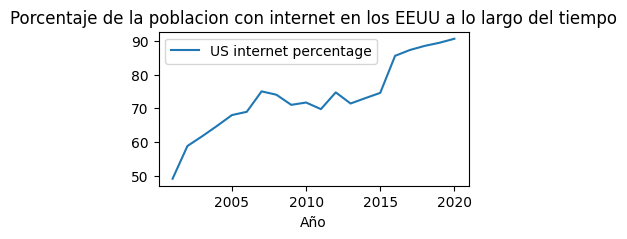

In [96]:
display(internet.tail())
display(internet.describe())
internet.plot(
    x=COLUMNA_FECHA,
    y='US internet percentage',
    title='Porcentaje de la poblacion con internet en los EEUU a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

In [97]:
## TODO: agregar dataset relacionado a los telefonos celular.

In [98]:
## TODO:
##  agregar dataset relacionado al avance de la IA, tengase en cuenta
##  que el avance de las redes neuronales se pueden medir con la cantidad de 
##  capas y neuronas utilizadas, mientras que el avance en transformers puede
##  medirse con la cantidad de parametros utilizados.
##  Otra manera de medir el avance podria ser mediante la cantidad de papers publicados.

In [99]:
## TODO: agregar dataset relacionado a la memoria SSD.

Unificamos todos los datasets limpios relacionados a la computacion en un solo dataframe y revisamos si se realizo correctamente

In [100]:
computer_advances = fusionar_por_fecha(computacion_dfs)
computer_advances.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Año                              20 non-null     int64  
 1   FGMOS transistor count           19 non-null     float64
 2   FPGA transistor count            19 non-null     float64
 3   GPU transistor count             20 non-null     float64
 4   Microprocessor transistor count  20 non-null     int64  
 5   US internet percentage           20 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 1.1 KB


### Revisando la economia de Estados Unidos

Los datos generales acerca la economia de los Estados Unidos pueden ser de gran ayuda para normalizar o escalar los datos, por ejemplo no es lo mismo el 1% de la poblacion en el 2005 que ese mismo porcentaje en el 2019, tambien puede ayudarnos el GDP para diferenciar si el crecimiento en una industria esta mas relacionada al crecimiento de la economia en general o si es un crecimiento independiente.

* Poblacion

Este dataset presenta las columnas:
- Country Name: nombre del pais.
- Country Code: codigo ISO del pais.
- Indicator Name: nombre del indicador.
- Indicator Code: codigo del indicador.
- 1960, 1961, ..., 2023: poblacion por año.

Este dataset se procesara de la misma manera que como fue tratado el dataset de Internet.

In [101]:
poblacion = pd.read_csv(f'{DATASETS_FOLDER}/theworldbank_population.csv')
poblacion.tail()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
261,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1818117.0,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1788878.0,1790133.0,1786038.0,NaN
262,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5542459.0,5646668.0,5753386.0,5860197.0,5973803.0,6097298.0,...,26984002.0,27753304.0,28516545.0,29274002.0,30034389.0,30790513.0,31546691.0,32284046.0,32981641.0,NaN
263,South Africa,ZAF,"Population, total",SP.POP.TOTL,16520441.0,16989464.0,17503133.0,18042215.0,18603097.0,19187194.0,...,53873616.0,54729551.0,55876504.0,56422274.0,56641209.0,57339635.0,58087055.0,58801927.0,59392255.0,NaN
264,Zambia,ZMB,"Population, total",SP.POP.TOTL,3119430.0,3219451.0,3323427.0,3431381.0,3542764.0,3658024.0,...,15234976.0,15737793.0,16248230.0,16767761.0,17298054.0,17835893.0,18380477.0,18927715.0,19473125.0,NaN
265,Zimbabwe,ZWE,"Population, total",SP.POP.TOTL,3806310.0,3925952.0,4049778.0,4177931.0,4310332.0,4447149.0,...,13555422.0,13855753.0,14154937.0,14452704.0,14751101.0,15052184.0,15354608.0,15669666.0,15993524.0,NaN


Poblacion: limpieza del dataset

In [102]:
poblacion = columna_fecha_a_fila(poblacion, 'United States', 'US Population')
poblacion = cortar_agregar_anios(poblacion)

Poblacion: muestreo del dataset limpio

,Año,US Population
56,2016,323071755.0
57,2017,325122128.0
58,2018,326838199.0
59,2019,328329953.0
60,2020,331501080.0


,Año,US Population
count,20.00000,2.000000e+01
mean,2010.50000,3.093169e+08
std,5.91608,1.450577e+07
min,2001.00000,2.849690e+08
25%,2005.75000,2.976641e+08
50%,2010.50000,3.104553e+08
75%,2015.25000,3.213222e+08
max,2020.00000,3.315011e+08


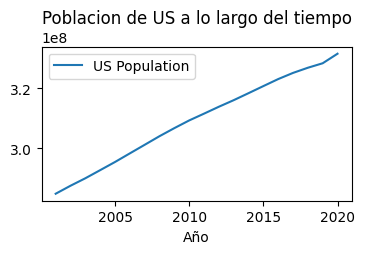

In [103]:
display(poblacion.tail())
display(poblacion.describe())
poblacion.plot(
    x=COLUMNA_FECHA,
    y='US Population',
    title='Poblacion de US a lo largo del tiempo',
    figsize=(4, 2),
    )
plt.show()

* GDP (producto domestico bruto)

Este dataset presenta las columnas:
- Country Name: nombre del pais.
- Country Code: codigo ISO del pais.
- Indicator Name: nombre del indicador.
- Indicator Code: codigo del indicador.
- 1960, 1961, ..., 2023: GDP por año.

Este dataset se procesara de la misma manera que como fue tratado el dataset de Internet.

In [104]:
gdp = pd.read_csv(f'{DATASETS_FOLDER}/theworldbank_gdp.csv')
gdp.tail()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
261,Kosovo,XKX,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,6.735731e+09,7.074658e+09,6.295820e+09,6.682833e+09,7.180813e+09,7.878509e+09,7.899879e+09,7.716925e+09,9.412034e+09,NaN
262,"Yemen, Rep.",YEM,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4.041523e+10,4.322859e+10,4.244450e+10,3.131783e+10,2.684223e+10,2.160616e+10,NaN,NaN,NaN,NaN
263,South Africa,ZAF,GDP (current US$),NY.GDP.MKTP.CD,8.748597e+09,9.225996e+09,9.813996e+09,1.085420e+10,1.195600e+10,1.306899e+10,...,4.008860e+11,3.811989e+11,3.467098e+11,3.235855e+11,3.814488e+11,4.041597e+11,3.885320e+11,3.376197e+11,4.190150e+11,NaN
264,Zambia,ZMB,GDP (current US$),NY.GDP.MKTP.CD,7.130000e+08,6.962857e+08,6.931429e+08,7.187143e+08,8.394286e+08,1.082857e+09,...,2.803724e+10,2.714102e+10,2.125122e+10,2.095841e+10,2.587360e+10,2.631159e+10,2.330867e+10,1.811063e+10,2.214763e+10,NaN
265,Zimbabwe,ZWE,GDP (current US$),NY.GDP.MKTP.CD,1.052990e+09,1.096647e+09,1.117602e+09,1.159512e+09,1.217138e+09,1.311436e+09,...,1.909102e+10,1.949552e+10,1.996312e+10,2.054868e+10,1.758489e+10,3.415607e+10,2.183223e+10,2.150970e+10,2.837124e+10,NaN


GDP: limpieza del dataset

In [105]:
gdp = columna_fecha_a_fila(gdp, 'United States', 'US GDP')
gdp = cortar_agregar_anios(gdp)
gdp = normalizar_con_la_poblacion(gdp, 'US GDP')

GDP: muestreo del dataset limpio

,Año,US GDP
56,2016,1.869511e+13
57,2017,1.947734e+13
58,2018,2.053306e+13
59,2019,2.138098e+13
60,2020,2.106047e+13


,Año,US GDP
count,20.00000,2.000000e+01
mean,2010.50000,1.582056e+13
std,5.91608,3.345485e+12
min,2001.00000,1.058193e+13
25%,2005.75000,1.362149e+13
50%,2010.50000,1.532435e+13
75%,2015.25000,1.832829e+13
max,2020.00000,2.138098e+13


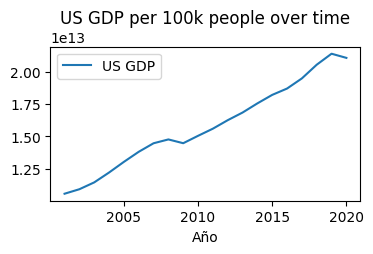

In [106]:
display(gdp.tail())
display(gdp.describe())
gdp.plot(
    x=COLUMNA_FECHA,
    y='US GDP',
    title='US GDP per 100k people over time',
    figsize=(4, 2),
    )
plt.show()

Unificamos todos los datasets procesados y limpios relacionados a la economia, en uno solo

In [107]:
economy = fusionar_por_fecha([gdp, poblacion])
economy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Año            20 non-null     int64  
 1   US GDP         20 non-null     float64
 2   US Population  20 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 640.0 bytes


### Procesando datos relacionado a la industria de los bienes raices

Para analizar esta industria con el mayor de los detalles, se procedera a procesar los datos y almacenar estos resultados en multiples columnas como por ejemplo; "ventas", "inversion", "inversion en propiedades de 1 familia", "inversion en propiedades de 2 familia", etc.

El dataset de bienes raices presenta las siguientes columnas:
- Date Recorded: fecha de registro.
- Sale Amount: precio al cual se vendio la propiedad en dolares.
- Property Type: clasificacion de la propiedad (segun MRC),
- Residential Type: clasificacion de la residencia (segun MRC).

Mas informacion acerca la clasificacion de viviendas: [Multifamily residential classification](https://en.wikipedia.org/wiki/Multifamily_residential).

In [108]:
bienes_raices_ventas = pd.read_csv(f'{DATASETS_FOLDER}/real_estate_sales.csv')
bienes_raices_ventas.info()

/tmp/ipykernel_18780/1248722542.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  bienes_raices_ventas = pd.read_csv(f'{DATASETS_FOLDER}/real_estate_sales.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997213 entries, 0 to 997212
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date Recorded     997211 non-null  object 
 1   Sale Amount       997213 non-null  float64
 2   Property Type     614767 non-null  object 
 3   Residential Type  608904 non-null  object 
dtypes: float64(1), object(3)
memory usage: 30.4+ MB


* Limpieza del dataset de bienes raices

In [109]:
bienes_raices_ventas = mantener_columnas(bienes_raices_ventas, [
    'Date Recorded', 'Sale Amount', 'Property Type', 'Residential Type',
    ])
# Guardamos el dataset ya "limpio" porque Github no admite archivos mayores a 100MB
if GUARDAR_DATOS_PROCESADOS:
    bienes_raices_ventas.to_csv(f'{DATASETS_FOLDER}/real_estate_sales.csv', index=False)
bienes_raices_ventas = fecha_a_anio(bienes_raices_ventas, 'Date Recorded')

/tmp/ipykernel_18780/3894518175.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columna_fecha] = df[columna_fecha].apply(lambda x: re.findall(fecha_regex, x)[0])


Bienes raices: muestro del dataset limpio

In [110]:
display(bienes_raices_ventas.tail())
display(bienes_raices_ventas.describe())

,Año,Sale Amount,Property Type,Residential Type
997208,2020,53100.0,Single Family,Single Family
997209,2019,76000.0,Single Family,Single Family
997210,2020,210000.0,Single Family,Single Family
997211,2020,280000.0,Single Family,Single Family
997212,2019,7450000.0,NaN,NaN


,Sale Amount
count,9.972110e+05
mean,3.911520e+05
std,5.347276e+06
min,0.000000e+00
25%,1.400000e+05
50%,2.250000e+05
75%,3.650000e+05
max,5.000000e+09


* Calculo de la cantidad de ventas por año

Se agrupara por año la cantidad de propiedades vendidas

In [111]:
# "BR" es un acronimo para Bienes Raices
br_ventas_por_anio = pd.DataFrame()
br_ventas_por_anio[COLUMNA_FECHA] = bienes_raices_ventas[COLUMNA_FECHA].unique()
br_ventas_por_anio = asegurar_tipo_de_dato_fecha(br_ventas_por_anio)
br_ventas_por_anio['re sales'] = bienes_raices_ventas.groupby(COLUMNA_FECHA).size().values
br_ventas_por_anio = cortar_agregar_anios(br_ventas_por_anio)
br_ventas_por_anio = br_ventas_por_anio.fillna(method='ffill')
br_ventas_por_anio = normalizar_con_la_poblacion(br_ventas_por_anio, 're sales')

Muestreo de las ventas por año calculadas

,Año,re sales
16,2016,48493
17,2017,47165
18,2018,52622
19,2019,62534
20,2020,14291


,Año,re sales
count,20.00000,20.000000
mean,2010.50000,47438.450000
std,5.91608,15192.165091
min,2001.00000,14291.000000
25%,2005.75000,37211.000000
50%,2010.50000,47388.000000
75%,2015.25000,56550.250000
max,2020.00000,79566.000000


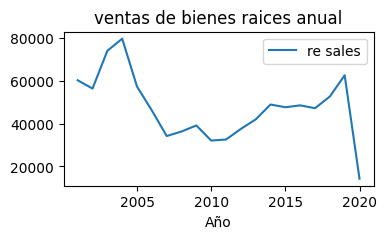

In [112]:
display(br_ventas_por_anio.tail())
display(br_ventas_por_anio.describe())
br_ventas_por_anio.plot(
    x=COLUMNA_FECHA,
    y='re sales',
    title='ventas de bienes raices anual',
    figsize=(4, 2)
    )
plt.show()

* Calculo de la suma de inversiones por año

Se agrupara por año la suma del valor de las propiedades vendidas

In [113]:
br_inversion_por_anio = pd.DataFrame()
br_inversion_por_anio[COLUMNA_FECHA] = bienes_raices_ventas[COLUMNA_FECHA].unique()
br_inversion_por_anio = asegurar_tipo_de_dato_fecha(br_inversion_por_anio)
br_inversion_por_anio['re investment'] = bienes_raices_ventas.groupby(COLUMNA_FECHA)['Sale Amount'].sum().values
br_inversion_por_anio = cortar_agregar_anios(br_inversion_por_anio)
br_inversion_por_anio = normalizar_con_la_poblacion(br_inversion_por_anio, 're investment')

Muestreo de las inversiones por año calculadas

,Año,re investment
16,2016,1.895052e+10
17,2017,1.844713e+10
18,2018,2.084145e+10
19,2019,2.721690e+10
20,2020,3.178363e+09


,Año,re investment
count,20.00000,2.000000e+01
mean,2010.50000,1.791407e+10
std,5.91608,6.191910e+09
min,2001.00000,3.178363e+09
25%,2005.75000,1.405080e+10
50%,2010.50000,1.782573e+10
75%,2015.25000,2.175421e+10
max,2020.00000,3.021333e+10


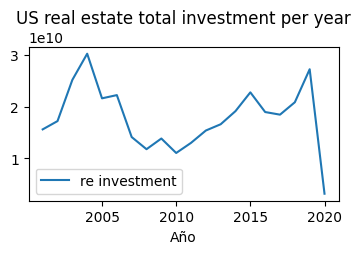

In [114]:
display(br_inversion_por_anio.tail())
display(br_inversion_por_anio.describe())
br_inversion_por_anio.plot(
    x=COLUMNA_FECHA,
    y='re investment',
    title='US real estate total investment per year',
    figsize=(4, 2)
    )
plt.show()

* Calculo de la inversion anual en bienes raices por cada tipo de propiedad y residencia

Se agrupara por cada tipo de propiedad y residencia la suma del valor de las propiedades vendidas anualmente. Podemos observar que poseemos los siguientes tipos de propiedades y residencias:

In [115]:
def obtener_categorias(df:pd.DataFrame, column:str) -> list:
    types = df[column].unique()
    types = [str(x) for x in types]
    return types
def imprimir_categorias(df: pd.DataFrame, column:str) -> None:
    types = obtener_categorias(df, column)
    for i, x in enumerate(types):
        print(f'{i+1}.\t{x}')

Tipos de residencias que tenemos presente en el dataset de bienes raices:

In [116]:
imprimir_categorias(bienes_raices_ventas, 'Residential Type')

1.	nan
2.	Single Family
3.	Condo
4.	Two Family
5.	Three Family
6.	Four Family


Tipos de propiedades que tenemos presente en el dataset de bienes raices:

In [117]:
imprimir_categorias(bienes_raices_ventas, 'Property Type')

1.	Commercial
2.	Residential
3.	Vacant Land
4.	nan
5.	Apartments
6.	Industrial
7.	Public Utility
8.	Condo
9.	Two Family
10.	Three Family
11.	Single Family
12.	Four Family


Procederemos a agrupar las ventas en diferentes categorias y las guardamos en columnas separadas

In [118]:
def agrupar_por_tipo_por_fecha(df:pd.DataFrame, column:str) -> pd.DataFrame:
    resultado = pd.DataFrame()
    resultado[COLUMNA_FECHA] = bienes_raices_ventas[COLUMNA_FECHA].unique()
    resultado = resultado.sort_values(by=COLUMNA_FECHA).reset_index(drop=True)
    #
    resultado = asegurar_tipo_de_dato_fecha(resultado)
    df = asegurar_tipo_de_dato_fecha(df)
    #
    for type in obtener_categorias(df, column):
        new_column_name = f're {type.upper()} investment'
        resultado[new_column_name] = 0
        for year in resultado[COLUMNA_FECHA]:
            sales_amount = df[(df[column] == type) & (df[COLUMNA_FECHA] == year)]['Sale Amount'].sum()
            resultado.loc[resultado[COLUMNA_FECHA] == year, new_column_name] = sales_amount
        resultado = normalizar_con_la_poblacion(resultado, new_column_name)
    return resultado

property_types_annual = agrupar_por_tipo_por_fecha(bienes_raices_ventas, 'Property Type')
residential_types_annual = agrupar_por_tipo_por_fecha(bienes_raices_ventas, 'Residential Type')

# Eliminamos las columnas que hayamos visto que tienen muchos valores en 0
property_types_annual = mantener_columnas(property_types_annual, [
    COLUMNA_FECHA,
    're CONDO investment',
    're TWO FAMILY investment',
    're THREE FAMILY investment',
    're SINGLE FAMILY investment',
    're FOUR FAMILY investment',
])
property_types_annual = mantener_columnas(property_types_annual, [
    COLUMNA_FECHA,
    're SINGLE FAMILY investment',
    're CONDO investment',
    're TWO FAMILY investment',
    're THREE FAMILY investment',
    're FOUR FAMILY investment',
])

Muestreo del calculo de ventas por cada tipo de propiedad

,Año,re SINGLE FAMILY investment,re CONDO investment,re TWO FAMILY investment,re THREE FAMILY investment,re FOUR FAMILY investment
17,2017,1.290385e+10,2.071585e+09,4.077366e+08,152915555,34627440
18,2018,1.185046e+10,1.913916e+09,4.677992e+08,201257041,71015671
19,2019,1.216468e+10,2.469696e+09,5.949037e+08,278538608,71852599
20,2020,1.359104e+10,1.732257e+09,4.329061e+08,216103966,202110732
21,2021,0.000000e+00,0.000000e+00,0.000000e+00,0,0


,Año,re SINGLE FAMILY investment,re CONDO investment,re TWO FAMILY investment,re THREE FAMILY investment,re FOUR FAMILY investment
count,22.000000,2.200000e+01,2.200000e+01,2.200000e+01,2.200000e+01,2.200000e+01
mean,2010.454545,7.092363e+09,1.246884e+09,2.389259e+08,1.028874e+08,3.071481e+07
std,6.573593,5.469519e+09,1.062153e+09,1.941756e+08,8.514759e+07,4.391946e+07
min,1999.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2005.250000,2.063103e+06,3.659750e+05,6.600000e+04,0.000000e+00,0.000000e+00
50%,2010.500000,9.254865e+09,1.483280e+09,2.743252e+08,1.112477e+08,2.264859e+07
75%,2015.750000,1.153239e+10,1.882366e+09,3.626263e+08,1.470617e+08,3.554375e+07
max,2021.000000,1.455175e+10,3.894486e+09,5.949037e+08,2.785386e+08,2.021107e+08


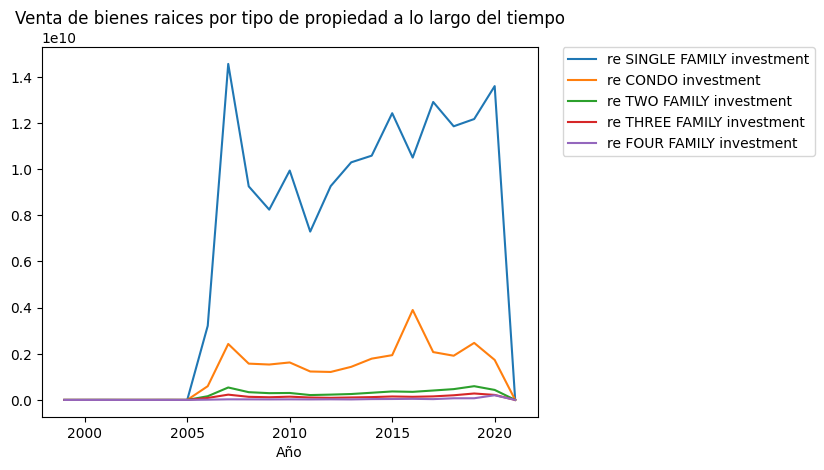

In [119]:
display(property_types_annual.tail())
display(property_types_annual.describe())
property_types_annual.plot(
    x=COLUMNA_FECHA,
    y=property_types_annual.columns[1:],
    title='Venta de bienes raices por tipo de propiedad a lo largo del tiempo',
    )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Muestreo del calculo de ventas por cada tipo de residencia

,Año,re NAN investment,re SINGLE FAMILY investment,re CONDO investment,re TWO FAMILY investment,re THREE FAMILY investment,re FOUR FAMILY investment
17,2017,0,1.290385e+10,2.071585e+09,4.077366e+08,1.529156e+08,34627440
18,2018,0,1.185046e+10,1.913916e+09,4.677992e+08,2.012570e+08,71015671
19,2019,0,1.216468e+10,2.469696e+09,5.949037e+08,2.785386e+08,71852599
20,2020,0,1.953491e+10,2.579188e+09,6.332712e+08,3.134679e+08,219821632
21,2021,0,1.638224e+10,4.375425e+09,6.710182e+08,5.073493e+08,68068605


,Año,re NAN investment,re SINGLE FAMILY investment,re CONDO investment,re TWO FAMILY investment,re THREE FAMILY investment,re FOUR FAMILY investment
count,22.000000,22.0,2.200000e+01,2.200000e+01,2.200000e+01,2.200000e+01,2.200000e+01
mean,2010.454545,0.0,8.107186e+09,1.484264e+09,2.785342e+08,1.303744e+08,3.461387e+07
std,6.573593,0.0,5.992677e+09,1.238747e+09,2.187378e+08,1.234736e+08,4.731333e+07
min,1999.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2005.250000,0.0,8.043554e+08,1.491894e+08,4.027347e+07,2.164980e+07,2.545675e+06
50%,2010.500000,0.0,9.596959e+09,1.552354e+09,2.969957e+08,1.189867e+08,2.393895e+07
75%,2015.750000,0.0,1.208612e+10,2.038284e+09,3.975201e+08,1.520068e+08,3.887281e+07
max,2021.000000,0.0,1.953491e+10,4.375425e+09,6.710182e+08,5.073493e+08,2.198216e+08


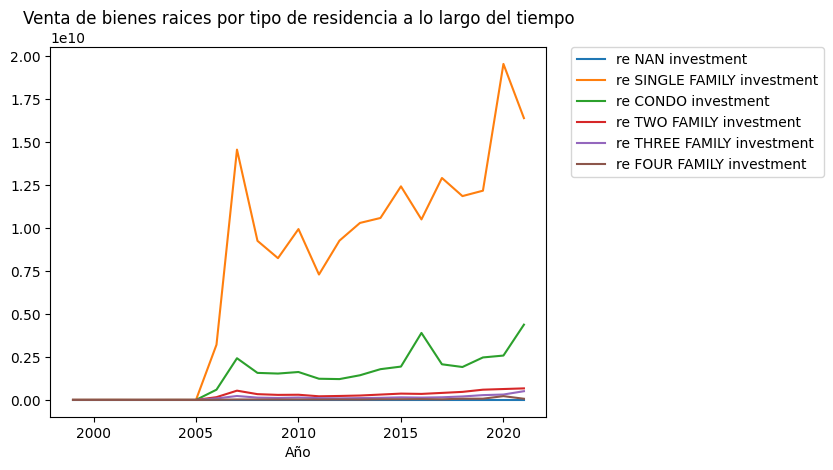

In [120]:
display(residential_types_annual.tail())
display(residential_types_annual.describe())
residential_types_annual.plot(
    x=COLUMNA_FECHA,
    y=residential_types_annual.columns[1:],
    title='Venta de bienes raices por tipo de residencia a lo largo del tiempo',
    )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Las ventas de bienes raices residenciales seran descartadas ya que es muy similar a las ventas de propiedades. Realizar el analisis con estos datos serian como duplicar la informacion.

Procederemos a agrupar los diferentes columnas que obtuvimos del procesamiento y las unificamos en un mismo dataset

In [121]:
bienes_raices = fusionar_por_fecha([
    br_ventas_por_anio, property_types_annual, br_inversion_por_anio,
    ])
bienes_raices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 1 to 20
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Año                          20 non-null     int64  
 1   re sales                     20 non-null     float64
 2   re SINGLE FAMILY investment  20 non-null     float64
 3   re CONDO investment          20 non-null     float64
 4   re TWO FAMILY investment     20 non-null     float64
 5   re THREE FAMILY investment   20 non-null     int64  
 6   re FOUR FAMILY investment    20 non-null     int64  
 7   re investment                20 non-null     float64
dtypes: float64(5), int64(3)
memory usage: 1.4 KB


### Procesando datasets relacionados a la industria de los libros

El dataset a utilizar fue obtendo de [scostap - Goodreads Best Book Ever dataset](https://github.com/scostap/goodreads_bbe_dataset), como los datos fueron scrapeados por el autor, para garantizar que los datos sean correctos, realizaremos una limpieza de outliers.

Este presenta las siguientes columnas:
- "bookId": id del libro.
- "title": titulo del libro.
- "series": serie del libro.
- "author": autor del libro.
- "rating": puntuacion del libro.
- "description": descripcion del libro
- "language": lenguaje del libro.
- "isbn": codigo isbn del libro.
- "genres": genero del libro.
- "characters": lista con nombres de los personajes.
- "bookFormat": formato del libro.
- "edition": edicion del libro.
- "pages": cantidad de paginas.
- "publisher": editorial.
- "publishDate": fecha de publicacion.
- "firstPublishDate": primera fecha de publicacion.
- "awards": premios ganados por el libro.
- "numRatings": numero de calificaciones.
- "ratingsByStars": calificacion por numero de estrellas.
- "likedPercent": porcentage de lectores que les gusto.
- "setting": no se esta seguro que es pero de todas maneras es irrevelante.
- "coverImg": url a la imagen de portada.
- "bbeScore": puntuacion del libro.
- "bbeVotes": numero de votos.
- "price": precio en dolares.

In [122]:
book = pd.read_csv(f'{DATASETS_FOLDER}/books_1.Best_Books_Ever.csv')
display(book.tail())

,bookId,title,series,author,rating,description,language,isbn,genres,characters,...,firstPublishDate,awards,numRatings,ratingsByStars,likedPercent,setting,coverImg,bbeScore,bbeVotes,price
52473,11492014-fractured,Fractured,Fateful #2,Cheri Schmidt (Goodreads Author),4.00,The Fateful Trilogy continues with Fractured. ...,English,2940012616562,"['Vampires', 'Paranormal', 'Young Adult', 'Rom...",[],...,NaN,[],871,"['311', '310', '197', '42', '11']",94.0,[],https://i.gr-assets.com/images/S/compressed.ph...,0,1,NaN
52474,11836711-anasazi,Anasazi,Sense of Truth #2,Emma Michaels,4.19,"'Anasazi', sequel to 'The Thirteenth Chime' by...",English,9999999999999,"['Mystery', 'Young Adult']",[],...,August 3rd 2011,[],37,"['16', '14', '5', '2', '0']",95.0,[],https://i.gr-assets.com/images/S/compressed.ph...,0,1,NaN
52475,10815662-marked,Marked,Soul Guardians #1,Kim Richardson (Goodreads Author),3.70,--READERS FAVORITE AWARDS WINNER 2011--Sixteen...,English,9781461017097,"['Fantasy', 'Young Adult', 'Paranormal', 'Ange...",[],...,March 15th 2011,"[""Readers' Favorite Book Award (2011)""]",6674,"['2109', '1868', '1660', '647', '390']",84.0,[],https://i.gr-assets.com/images/S/compressed.ph...,0,1,7.37
52476,11330278-wayward-son,Wayward Son,NaN,"Tom Pollack (Goodreads Author), John Loftus (G...",3.85,A POWERFUL TREMOR UNEARTHS AN ANCIENT SECRETBu...,English,9781450755634,"['Fiction', 'Mystery', 'Historical Fiction', '...",[],...,April 5th 2011,[],238,"['77', '78', '59', '19', '5']",90.0,[],https://i.gr-assets.com/images/S/compressed.ph...,0,1,2.86
52477,10991547-daughter-of-helaman,Daughter of Helaman,Stripling Warrior #1,Misty Moncur (Goodreads Author),4.02,Fighting in Helaman's army is Keturah's deepes...,English,9781599554976,"['Lds Fiction', 'Historical Fiction', 'Young A...",[],...,NaN,[],246,"['106', '73', '42', '17', '8']",90.0,[],https://i.gr-assets.com/images/S/compressed.ph...,0,1,5.20


Limpieza del dataset de libros

In [123]:
book = mantener_columnas(book, [
    'bookFormat', 'pages', 'publishDate', 'rating', 'likedPercent', 'price'
    ])
book = book.dropna()
# Formateamos la fecha
book = book[book['publishDate'].str.match(r'\d{1,2}/\d{1,2}/\d{2}')]
book['publishDate'] = pd.to_datetime(book['publishDate'],format="%m/%d/%y")
book['publishDate'] = book['publishDate'].dt.strftime('%Y-%m-%d')
# Nos aseguramos que estas columnas son numericas y no nulas
for col in ['pages', 'rating', 'likedPercent', 'price']:
    book = book[pd.to_numeric(book[col], errors='coerce').notnull()]
    book[col] = book[col].astype(float)

Muestreo de los datos limpios

In [124]:
display(book.tail())
display(book.describe())

,bookFormat,pages,publishDate,rating,likedPercent,price
814,Mass Market Paperback,357.0,2008-04-29,4.30,97.0,2.86
815,Paperback,515.0,2005-09-22,3.65,86.0,2.86
816,Paperback,416.0,2001-02-01,4.17,95.0,3.55
818,Hardcover,516.0,2014-10-07,4.41,97.0,6.52
819,Hardcover,528.0,2010-04-27,4.40,97.0,6.50


,pages,rating,likedPercent,price
count,657.000000,657.000000,657.000000,657.000000
mean,423.127854,4.076514,92.576865,6.025403
std,289.973231,0.233532,3.742140,7.746120
min,26.000000,3.410000,78.000000,0.850000
25%,272.000000,3.930000,91.000000,2.900000
50%,369.000000,4.060000,93.000000,4.180000
75%,503.000000,4.230000,95.000000,6.270000
max,4100.000000,4.820000,99.000000,110.670000


Veamos la distribucion de los datos para analizar si son correctos e indicados para el analisis

<Axes: xlabel='rating', ylabel='Count'>

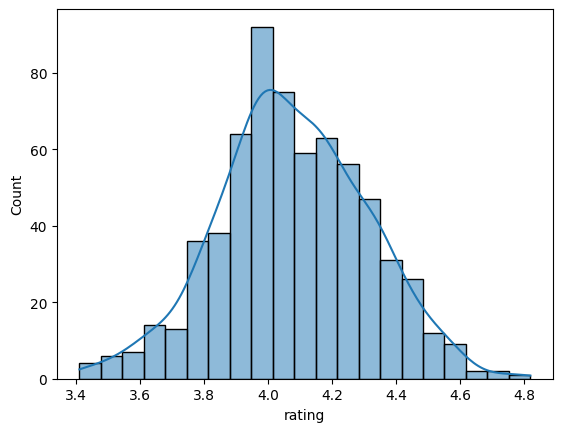

In [125]:
# NOTE: sns.hisplot solo muestra un grafico por celda.
sns.histplot(book['rating'], kde=True)

<Axes: xlabel='likedPercent', ylabel='Count'>

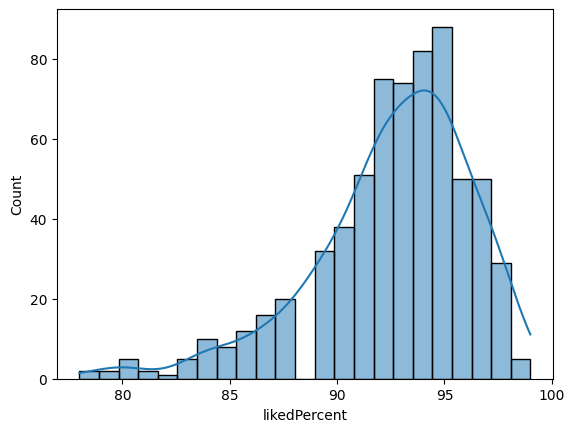

In [126]:
sns.histplot(book['likedPercent'], kde=True)

<Axes: xlabel='price', ylabel='Count'>

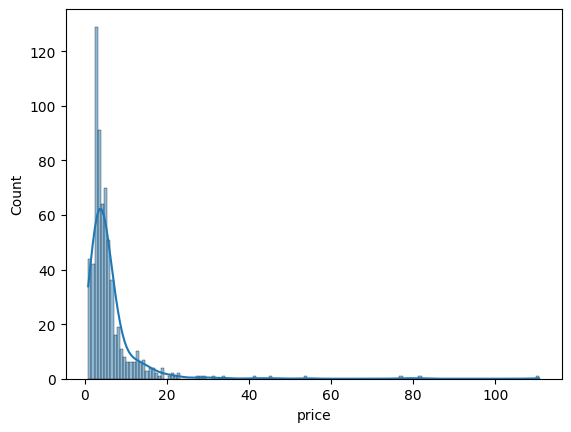

In [127]:
sns.histplot(book['price'], kde=True)

Podemos ver que tenemos libros con precios muy altos y alejados del "monton", esto puede afectar el analisis, continuemos analisando estos datos...

* Tratando los outliers

# Outliers


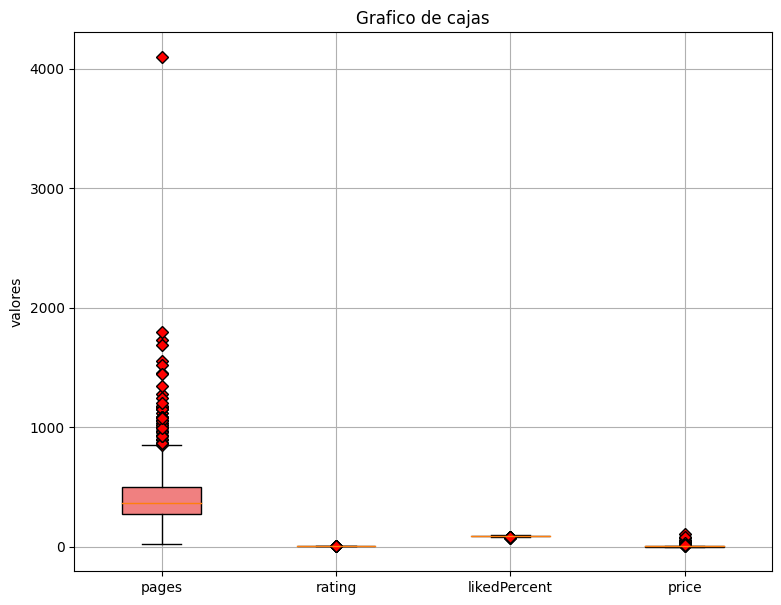

In [128]:
print('# Outliers')

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))
bplot = ax1.boxplot(
    book.select_dtypes(include = ["float64"]),
    vert=True,
    patch_artist=True,
    labels=['pages','rating', 'likedPercent', 'price'],
    flierprops=dict(markerfacecolor='r', marker='D')
    )
ax1.set_title('Grafico de cajas')

colors = ['lightcoral', 'mediumpurple', 'gold','aquamarine']

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

for ax in [ax1]:
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    ax.set_ylabel('valores')

plt.show()

Removiendo outliers usando Z score en todas las columnas

In [129]:
def mostrar_min_max(df:pd.DataFrame, column:str) -> None:
    print(f'\tmin {column}: {df[column].min()}\tmax {column}: {df[column].max()}')

threshold = 3
for column in ['pages', 'rating', 'likedPercent', 'price']:
    z = np.abs(stats.zscore(book['pages']))
    book = book[(z < threshold)]

### Analizando el impacto de los avances de la computacion en las ventas de bienes raices

A continuacion analizaremos los datos de los avances en computacion y de bienes raices para ver si encontramos alguna correlacion y si logramos poder proyectar alguna regresion.

Ignoraremos las correlaciones que existan entre columnas propias de la computacion o de los bienes raices, es decir por ejemplo: alguna correlacion entre la cantidad de transistores en los Microprocesadores y la cantidad de transistores en las GPU, esto es debido a que solo nos interesa como afecta una industria a otra, no a si misma.

* Unificacion de las columnas de avances en computacion y avances en bienes raices

In [130]:
computacion_y_bienes_raices = fusionar_por_fecha([computer_advances, bienes_raices])
numeric_df = computacion_y_bienes_raices.select_dtypes(include=['float64', 'int', 'int64'])
columns_to_analize_correlation = numeric_df.columns[1:]

* Analizando correlaciones entre la computacion y bienes raices

Procederemos a buscar correlaciones entre las columnas relacionadas a la computacion y las columnas relacionadas a los bienes raices, para ver si es posible proyectar alguna regresion.

<Axes: >

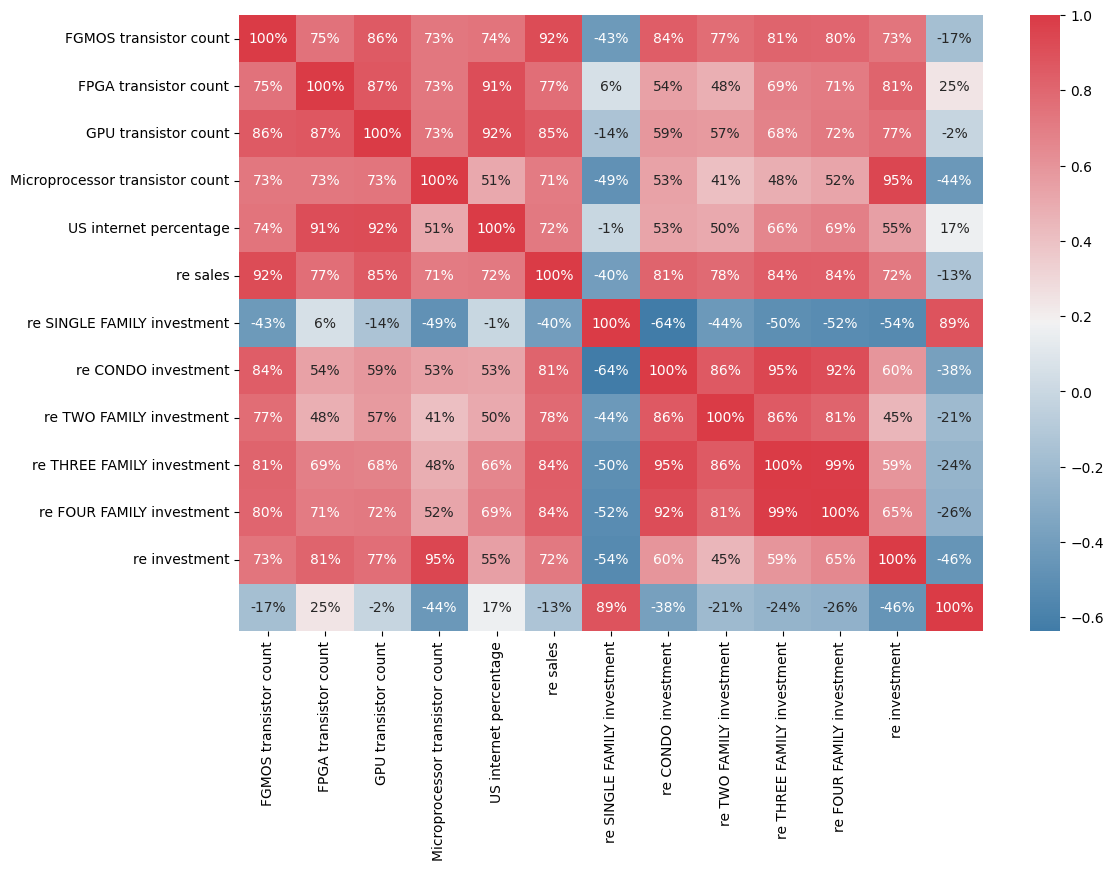

In [131]:
corr = computacion_y_bienes_raices.corr()
plt.subplots(figsize=(12,8))
sns.heatmap(
    corr,
    xticklabels=columns_to_analize_correlation,
    yticklabels=columns_to_analize_correlation,
    annot=True,
    fmt='.0%',
    cmap=sns.diverging_palette(240, 10, as_cmap=True)
    )

En la grafica de calor podemos observar que en general, hay una alta correlacion entre las columnas de la computacion y las columnas de los bienes raices, teniendo la mayor correlacion las columnas de "Microprocessor transistor count" (cantidad de transistores en los microprocesadores) y la columna "re investment" (inversion en bienes raices) con un 95%, lo que nos indica que tenemos unas buenas chances de poder proyectar una regresion mas adelante.

Veamos en detalle las correlaciones que existen con las columnas "re sales" (ventas de bienes raices) y "re investment" (inversion en bienes raices), vemos estas en profundidad ya que estas abarcan a todas las demas columnas de bienes raices.

In [132]:
print("Variables mas correlacionadas con la inversion total en bienes raices")
display(corr['re investment'].abs().sort_values(ascending=False))
print("Variables mas correlacionadas con la cantidad total de ventas en bienes raices")
display(corr['re sales'].abs().sort_values(ascending=False))

Variables mas correlacionadas con la inversion total en bienes raices


re investment                      1.000000
re sales                           0.891257
re FOUR FAMILY investment          0.463065
GPU transistor count               0.441144
re SINGLE FAMILY investment        0.381849
re THREE FAMILY investment         0.263131
FGMOS transistor count             0.245910
re TWO FAMILY investment           0.243688
re CONDO investment                0.205083
Año                                0.174011
Microprocessor transistor count    0.167502
US internet percentage             0.133680
FPGA transistor count              0.018511
Name: re investment, dtype: float64

Variables mas correlacionadas con la cantidad total de ventas en bienes raices


re sales                           1.000000
re investment                      0.891257
re SINGLE FAMILY investment        0.635902
re FOUR FAMILY investment          0.539678
re THREE FAMILY investment         0.521715
re TWO FAMILY investment           0.501825
GPU transistor count               0.487257
re CONDO investment                0.435862
Año                                0.428682
US internet percentage             0.399518
FPGA transistor count              0.142902
FGMOS transistor count             0.056822
Microprocessor transistor count    0.008890
Name: re sales, dtype: float64

Podemos observar que el avance computacional mas correlacionado con los bienes raices fue el de las GPU, ya que tiene un coeficiente de 0.48 en relacion con las ventas y 0.48 con las inversiones, recordemos que segun el [coeficiente de correlacion de Pearson](https://es.wikipedia.org/wiki/Coeficiente_de_correlaci%C3%B3n_de_Pearson), valores cercanos a 1 (o -1) es una correlacion perfecta y cercanos a 0 es una correlacion nula.

Sin embargo, un coeficiente de 0.48 sigue estando muy alejado del perfecto 1, por lo tanto sigamos buscando correlaciones utilizando una grafica de pares (pairplot).

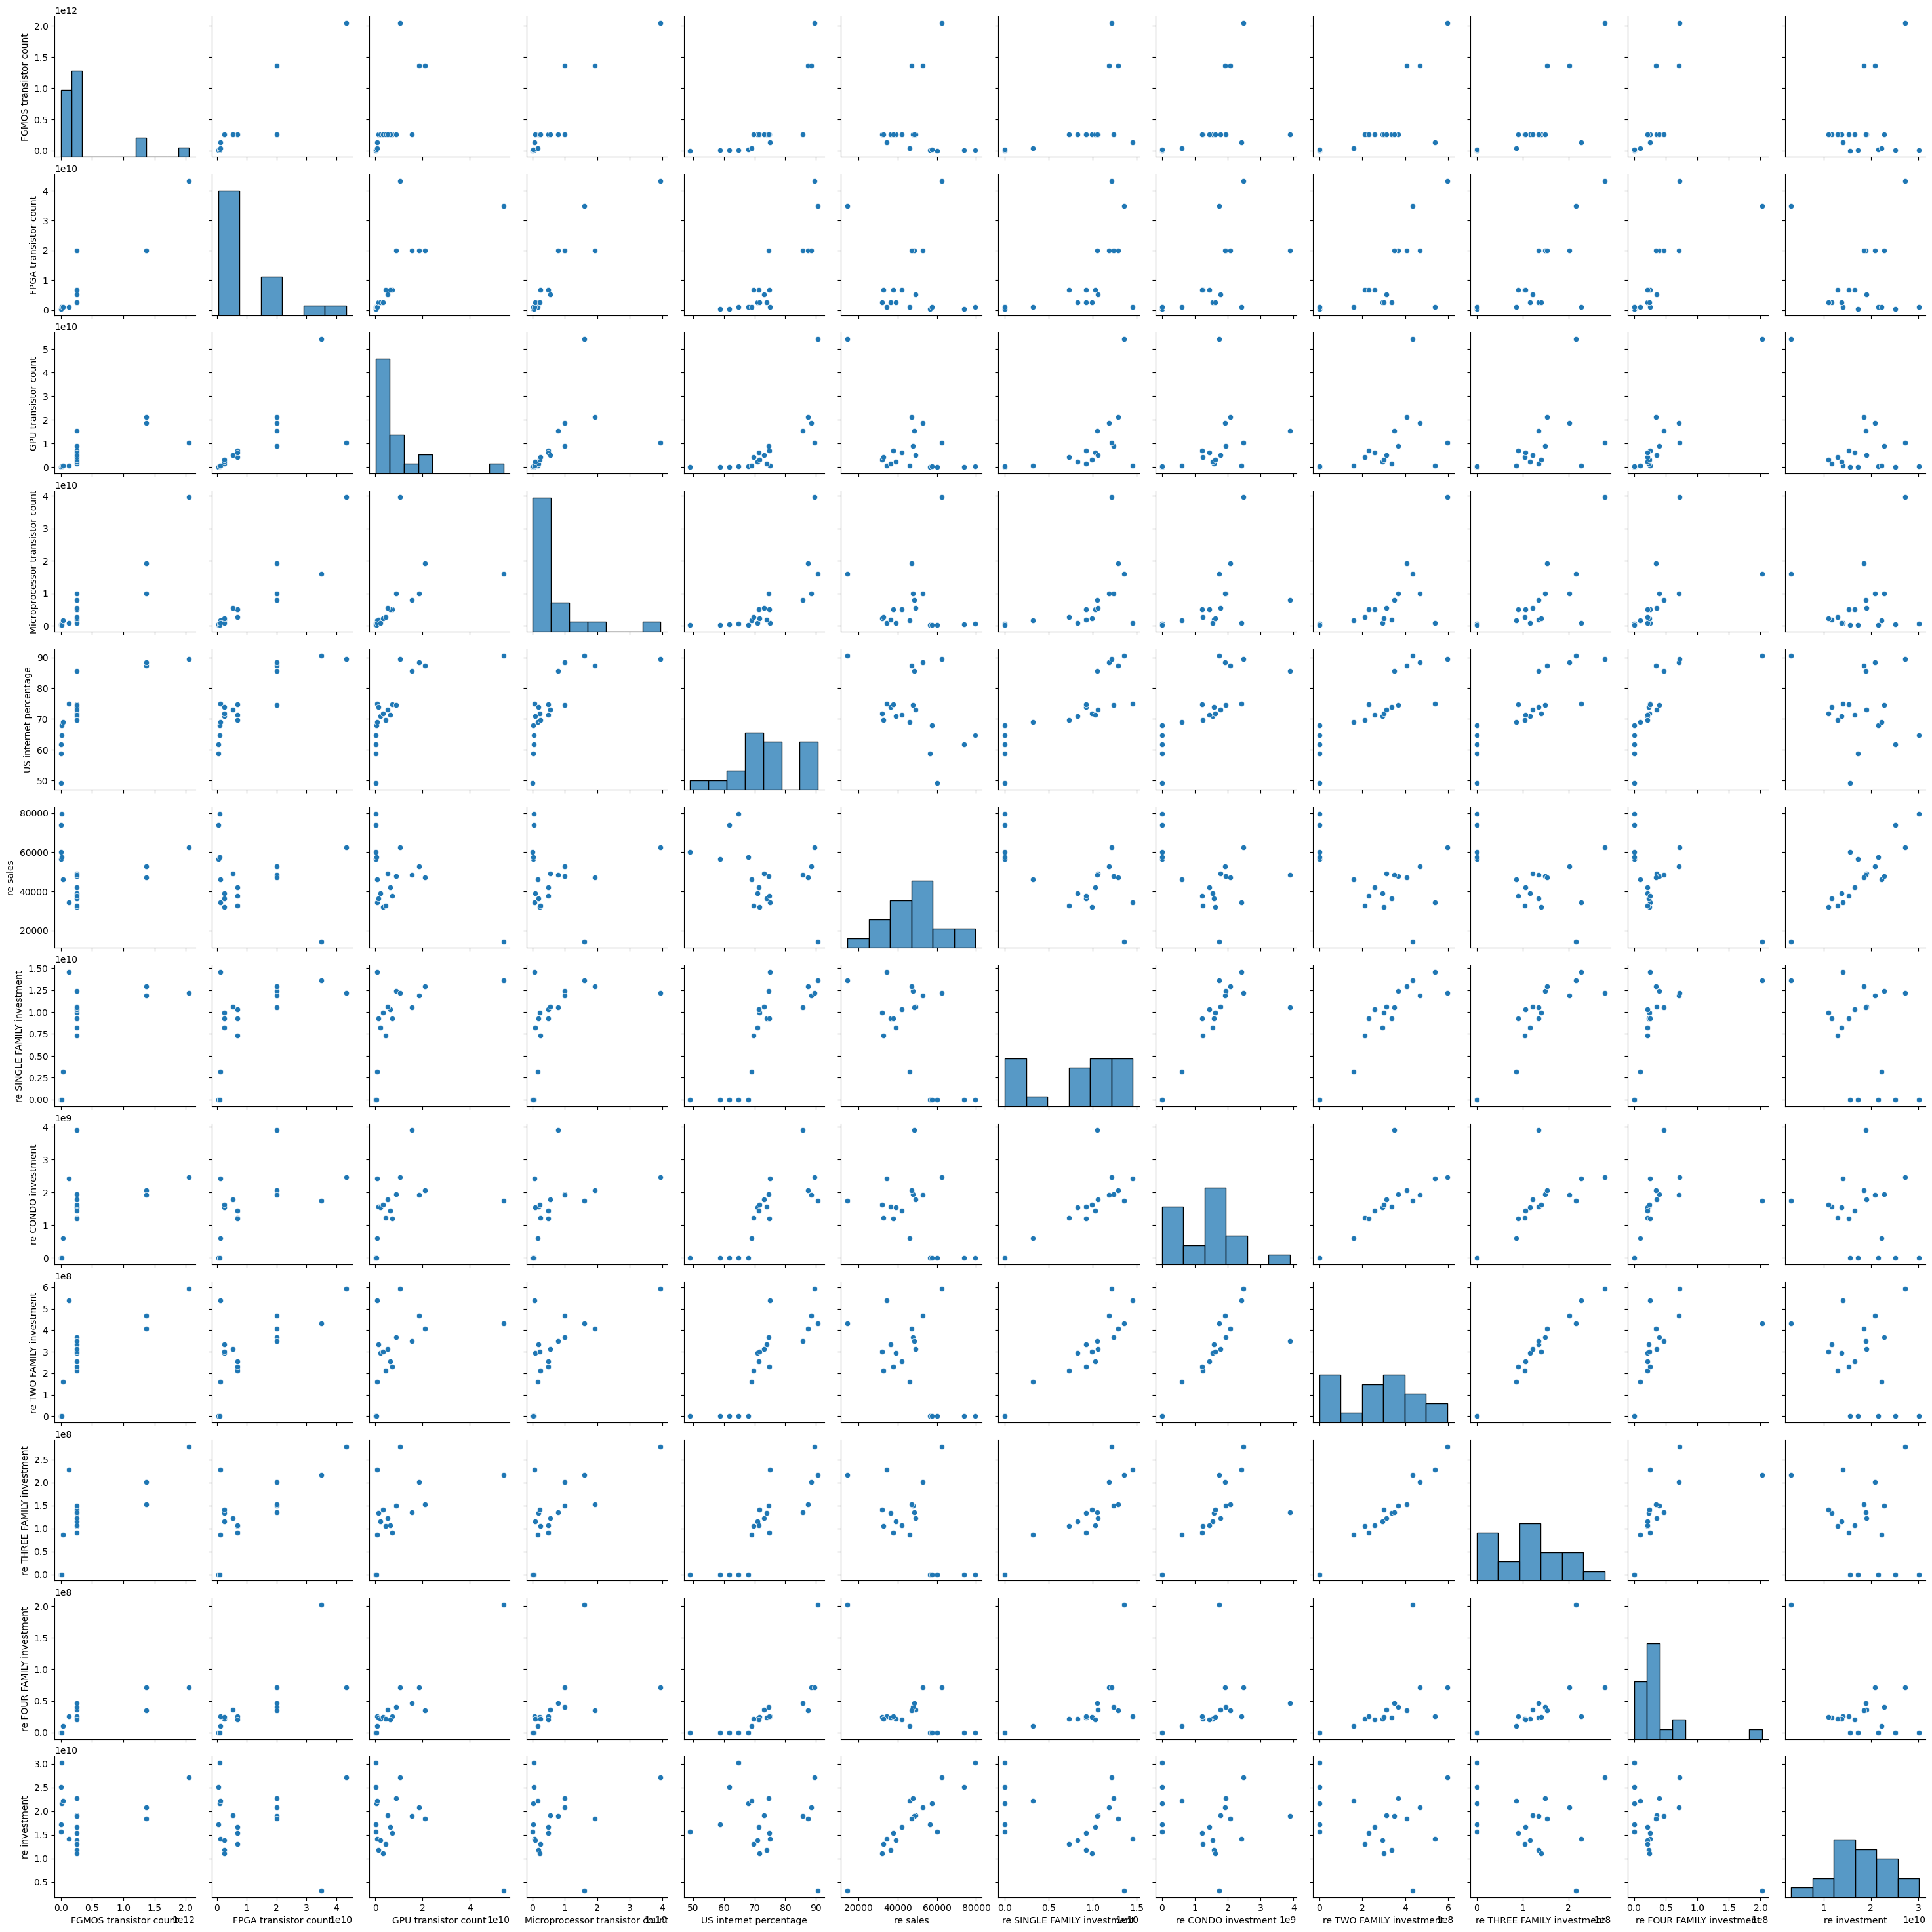

In [133]:
pp = sns.pairplot(
    numeric_df,
    x_vars=columns_to_analize_correlation,
    y_vars=columns_to_analize_correlation
    )

Podemos observar visualmente que hay correlaciones entre varias columnas, algunas de ellas son:

- "US internet percentage" con "re THREE FAMILY investment".
- "Microprocessor transistor count" con "re SINGLE FAMILY investment".

Tambien podemos ver correlaciones muy claras entre columnas de bienes raices pero recordemos que esas correlaciones estan fuera de nuestra investigacion.

Veamos en detalle estas correlaciones encontradas en el pairplot e intentemos hacer algunas proyecciones utilizando regresiones.

* Proyectando regresion lineal de "Porcentaje de la poblacion con acceso a internet" con "Inversion en propiedades de 3 familias"

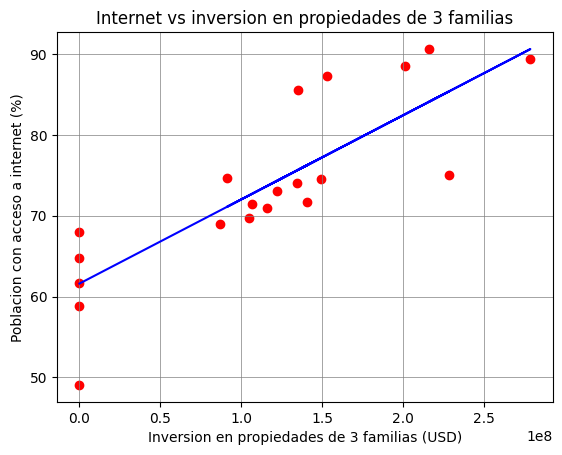

In [134]:
X = computacion_y_bienes_raices['re THREE FAMILY investment'].values.reshape(-1,1)
y = computacion_y_bienes_raices['US internet percentage'].values.reshape(-1,1)
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
#
plt.scatter(X, y, color = "red")
plt.plot(X, lin_reg.predict(X), color = "blue")
plt.title("Internet vs inversion en propiedades de 3 familias")
plt.xlabel("Inversion en propiedades de 3 familias (USD)")
plt.ylabel("Poblacion con acceso a internet (%)")
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

Analizamos el error de la regresion lineal realizada

In [135]:
def imprimir_error(y, y_test, y_pred) -> None:
    """Imprime el error"""
    valor_medio_y = np.mean(y)
    print('Valor medio Y:', valor_medio_y)
    print('Error Absoluto Medio:', metrics.mean_absolute_error(y_test, y_pred))
    print('Error Cuadratico Medio:', metrics.mean_squared_error(y_test, y_pred))
    raiz_error_cuadratico_medio = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('Raíz del error cuadrático medio:', raiz_error_cuadratico_medio)
    print('Porcentaje de error medio: ', (raiz_error_cuadratico_medio / valor_medio_y) * 100, '%')

In [136]:
y_pred = lin_reg.predict(X_test)
imprimir_error(y, y_test, y_pred)

Valor medio Y: 73.3831743565
Error Absoluto Medio: 3.2910443763133674
Error Cuadratico Medio: 14.716047558868215
Raíz del error cuadrático medio: 3.836150095977504
Porcentaje de error medio:  5.227560853856293 %


Podemos observar que la raiz del error cuadratico medio es bajo (5.22%), lo que nos indica que la regresion lineal es muy buena.

* Proyectando regresion polinomica en "Cantidad de transistores en el microprocesador" con "Inversion en propiedades de 1 familia"

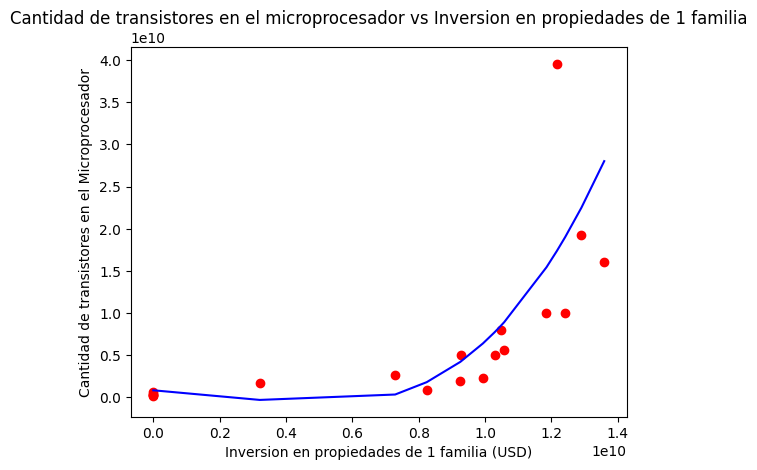

In [137]:
# Removemos este valor (solo es una fila) para tener un mejor grafico mas claro.
computacion_y_bienes_raices = computacion_y_bienes_raices[computacion_y_bienes_raices['re SINGLE FAMILY investment'] < 14000000000]
# Ordenamos el eje X para evitar una prediccion polinomial horrible
computacion_y_bienes_raices = computacion_y_bienes_raices.sort_values(by=['re SINGLE FAMILY investment'])
#
y = computacion_y_bienes_raices['Microprocessor transistor count'].values.reshape(-1,1)
X = computacion_y_bienes_raices['re SINGLE FAMILY investment'].values.reshape(-1,1)
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#
poly_reg=PolynomialFeatures(degree=3)
X_poly=poly_reg.fit_transform(X_train)
poly_reg.fit(X_poly, y_train)
lin_reg2=LinearRegression()
lin_reg2.fit(X_poly, y_train)
#
plt.scatter(X,y,color='red')
plt.plot(X,lin_reg2.predict(poly_reg.fit_transform(X)),color='blue')
plt.title('Cantidad de transistores en el microprocesador vs Inversion en propiedades de 1 familia')
plt.xlabel('Inversion en propiedades de 1 familia (USD)')
plt.ylabel('Cantidad de transistores en el Microprocesador')
plt.show()

Analizamos el error de la regresion polinomica realizada

In [138]:
y_pred = lin_reg2.predict(poly_reg.fit_transform(X_test))
imprimir_error(y, y_test, y_pred)

Valor medio Y: 6808789473.684211
Error Absoluto Medio: 4744194549.005621
Error Cuadratico Medio: 4.163901104500549e+19
Raíz del error cuadrático medio: 6452829692.856111
Porcentaje de error medio:  94.77205482407885 %


Podemos observar que la raiz del error cuadratico medio es demaciado grande comparandolo con el valor medio Y (94.77%), lo que indica que la regresion polinomica no es correcta para este caso.

Hasta ahora hemos podido observar con el analisis de las correlaciones y las regresiones, algunos avances en la computacion (por ejemplo en las GPU e internet) han tenido un impacto en las ventas de propiedades de bienes raices, mientras que otros avances como la cantidad de transistores en los microprocesadores queda inconcluso ya que la regresion polinomica nos arroja un error bastante grande.

Ahora veamos cuanto han impactado cada una de todos los avances aplicando una regresion lineal multiple y analizando los coeficientes de cada una de las columnas.

* Analizando cuanto fue el impacto en la INVERSION de bienes raices aplicando una regresion lineal multiple

In [139]:
df = computacion_y_bienes_raices
df = df.dropna()
#
X = mantener_columnas(
    df,
    df.columns[1:-1].tolist()
    )
y = df['re investment'].values
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
df = df.drop(columns=['re investment', COLUMNA_FECHA], axis=1)
df = df.T
df = df.index
coeff_df = pd.DataFrame(regressor.coef_, df, columns=['Coefficient'])
coeff_df

,Coefficient
FGMOS transistor count,-2.224972e-02
FPGA transistor count,-6.263645e-02
GPU transistor count,8.760943e-03
Microprocessor transistor count,9.342333e-01
US internet percentage,1.255950e+09
re sales,2.285855e+05
re SINGLE FAMILY investment,4.920637e-01
re CONDO investment,-8.669829e+00
re TWO FAMILY investment,-5.435284e+01
re THREE FAMILY investment,4.441178e+01


Calculamos el error

In [140]:
y_pred = regressor.predict(X_test)
imprimir_error(y, y_test, y_pred)

Valor medio Y: 19139888823.94294
Error Absoluto Medio: 5125759615.06068
Error Cuadratico Medio: 3.407296941211635e+19
Raíz del error cuadrático medio: 5837205616.741315
Porcentaje de error medio:  30.497594162821333 %


Podemos observar que obtuvimos una raiz del error cuadratico es medio muy alto con respecto al valor medio Y (30%) aunque sigue siendo aceptable.

De estos coeficientes podemos observar que por cada porcentaje de la poblacion con acceso a internet, la inversion en bienes raices aumenta 1.2x10^9 USD.

* Analizando el impacto en las VENTAS de bienes raices aplicando una regresion lineal multiple

In [141]:
df = computacion_y_bienes_raices
df = df.dropna()
#
X = mantener_columnas(
    df,
    df.columns[1:-1].tolist()
    )
y = df['re sales'].values
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
df = df.drop(columns=['re sales', COLUMNA_FECHA], axis=1)
df = df.T
df = df.index
coeff_df = pd.DataFrame(regressor.coef_, df, columns=['Coefficient'])
coeff_df

,Coefficient
FGMOS transistor count,-1.503254e-20
FPGA transistor count,8.963740e-17
GPU transistor count,2.921871e-17
Microprocessor transistor count,-7.050621e-17
US internet percentage,4.339115e-08
re SINGLE FAMILY investment,1.000000e+00
re CONDO investment,-1.716786e-16
re TWO FAMILY investment,-1.225563e-16
re THREE FAMILY investment,6.510148e-17
re FOUR FAMILY investment,-7.962270e-15


Calculamos el error

In [142]:
y_pred = regressor.predict(X_test)
imprimir_error(y, y_test, y_pred)

Valor medio Y: 49416.23529411765
Error Absoluto Medio: 7.449389158864506e-07
Error Cuadratico Medio: 6.926872127182638e-13
Raíz del error cuadrático medio: 8.322783264739409e-07
Porcentaje de error medio:  1.6842204217305332e-09 %


Podemos ver que la raiz de error cuadratico medio es bastante (sospechosamente) bajo comparandolo con el valor medio de Y, lo que nos dice que los coeficientes de la regresion lineal multiple son bastante acertados, pero tambien este error excesivamente bajo puede deberse a que la cantidad de datos es pequeña.

De esta ultima regresion lineal multiple, podemos observar que por cada % de poblacion que utiliza internet, las ventas de bienes raices se incrementan un 4.339115e-08, practicamente 0 lo que podemos decir que no impacto en la cantidad de ventas directamente.

### Conclusion

En esta investigacion hemos podido observar que los avances en la computacion y los bienes raices tienen una buena correlacion, hemos podido proyectar regresiones lineales, polinomicas y calcular mediante regresiones lineales multiples cual es el coeficiente con el cual impacta cada avance computacional en las ventas e inversion de bienes raices.

Observamos que el avance en Microprocesadores y GPUs son las que tienen las mejores correlaciones, y hemos podido observar mediante las regresiones lineales multiples, que el internet es la tecnologia que mas peso tuvo en las inversiones de bienes raices (1.2x10^9 USD por % de poblacion con internet) pero sin embargo, no afecto tanto a las ventas (4.339115e-08 ventas, cero practicamente).

Pero sin embargo se debe tener en cuenta que la industria de bienes raices fue altamente afectada por la burbuja del 2008, por lo que se debe continuar investigando en otras industrias (como la de los libros) para poder llegar a una conclusion mas solida.